In [1]:
from scipy import stats
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels
# from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn import metrics

from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')
plt.style.use('bmh')

def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))
    
def ts_metrics(y_true, y_pred):
    return {
        'mae': metrics.mean_absolute_error(y_true, y_pred),
        'mse': metrics.mean_squared_error(y_true, y_pred),
        # 'mape': np.mean(np.abs((y_true - y_pred) / y_true)),
        # 'smape': np.mean(np.abs( 2*(y_true - y_pred) / (y_true+np.abs(y_pred)))),
        # 'nmse':  np.sum((y_true - y_pred)**2) / np.sum((y_true)**2),
    }

c:\Users\pc\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\pc\Anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [2]:
ocean_discord = pd.read_csv('data/oceandiscord.csv')
ocean_discord['Date'] = pd.to_datetime(ocean_discord['Date'].astype(str).str[:10]) #just days
# Group by 'Date' and aggregate counts of messages, attachments, and reactions
daily_activity = ocean_discord.groupby('Date').agg({
    'Content': 'count',       # Count of messages
}).reset_index()

daily_activity = daily_activity[['Date', 'Content']]

feat = 'Content'
df1 = daily_activity.reset_index().rename(columns = {'Date': 'ds', feat: 'y'})[['ds','y']]

x = df1.set_index('ds').y
x

ds
2019-08-20     3
2019-08-21     2
2019-08-22    16
2019-08-23     1
2019-08-24     1
              ..
2024-02-16    12
2024-02-17    15
2024-02-18    41
2024-02-19    45
2024-02-20    45
Name: y, Length: 1537, dtype: int64

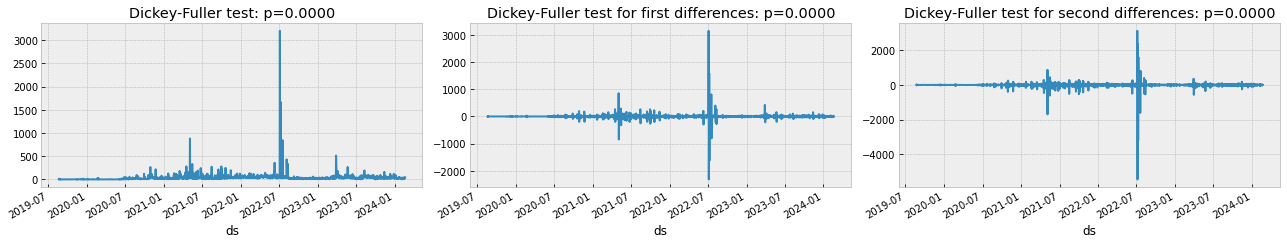

In [3]:
# Stationarity
_, ax = plt.subplots(1,3, figsize = (18,3.5))
x1 = x
test_res = sm.tsa.stattools.adfuller(x1)
t = f"Dickey-Fuller test: p={test_res[1]:.4f}"# {test_res[0]:.4f}"
_ = x1.plot(title = t, ax = ax[0])

x1 = x.diff(1)[1:]
test_res = sm.tsa.stattools.adfuller(x1)
t = f"Dickey-Fuller test for first differences: p={test_res[1]:.4f}"# {test_res[0]:.4f}"
_ = x1.plot(title = t, ax = ax[1])

x1 = x.diff(1).diff(1)[2:]
test_res = sm.tsa.stattools.adfuller(x1)
t = f"Dickey-Fuller test for second differences: p={test_res[1]:.4f}"# {test_res[0]:.4f}"
_ = x1.plot(title = t, ax = ax[2])
plt.tight_layout()

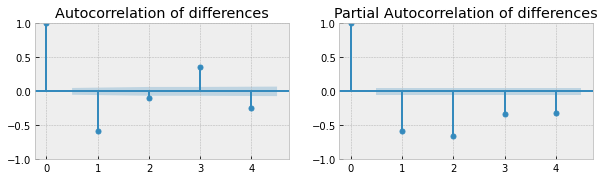

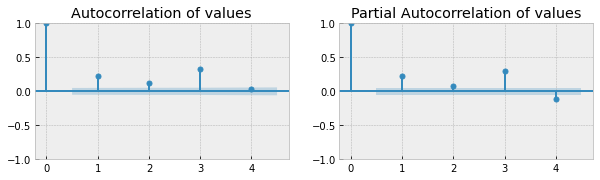

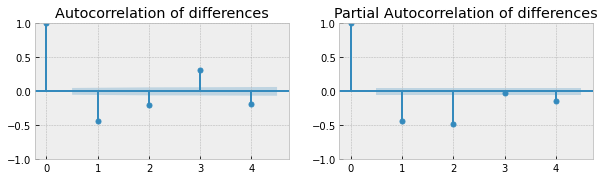

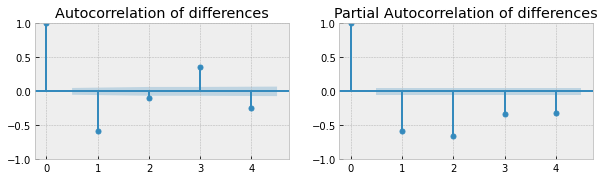

In [4]:
l = 4
_, ax = plt.subplots(1,2, figsize = (10,2.5))
sm.graphics.tsa.plot_acf( x, lags=l, ax = ax[0], title = 'Autocorrelation of values')
sm.graphics.tsa.plot_pacf(x, lags=l, ax = ax[1], title = 'Partial Autocorrelation of values')

x1 = x.diff(1)[1:]
_, ax = plt.subplots(1,2, figsize = (10,2.5))
sm.graphics.tsa.plot_acf( x1, lags=l, ax = ax[0], title = 'Autocorrelation of differences')
sm.graphics.tsa.plot_pacf(x1, lags=l, ax = ax[1], title = 'Partial Autocorrelation of differences')

x1 = x.diff(1).diff(1)[2:]
_, ax = plt.subplots(1,2, figsize = (10,2.5))
sm.graphics.tsa.plot_acf( x1, lags=l, ax = ax[0], title = 'Autocorrelation of differences')
sm.graphics.tsa.plot_pacf(x1, lags=l, ax = ax[1], title = 'Partial Autocorrelation of differences')

In [5]:
import itertools
ps = range(0, 4) # by partial autocorr
ds = range(0, 3)
qs = range(0, 4) # by autocorr

parameters = itertools.product(ps, ds, qs, [0], [0], [0], [0])
parameters_list = list(parameters)
print(len(parameters_list))

48


In [8]:
%%time
list_param = []
list_res   = []
list_time  = []
list_pred  = []
import gc
import time
n1 = 365

for p in parameters_list:
    t1 = time.time()
    list_res1 = list()
    list_pred1 = list()
    # train-valid split
    for k in range(1):
        train, valid = x[:-n1], x[-n1:]
        
        # train
        try:
            model_arima = sm.tsa.statespace.SARIMAX(train, order=(p[0],p[1],p[2]), seasonal_order=(p[3],p[4],p[5],p[6]))
            model_arima = model_arima.fit(disp=-1)
        except Exception as e:
            print(p, e)
            break
            
        # predict
        pred = model_arima.predict(start = 0, end = n - 1)
        pred = pred[-n1:]
        list_pred1 += list(pred)
        
        # evaluate
        res = ts_metrics(valid, pred)
        list_res1.append(res)
        
        del model_arima
        gc.collect()
        
        # break
        
    # collect
    if len(list_pred1) > 0:
        list_pred.append(list_pred1)
        list_res.append(pd.DataFrame(list_res1).mean())
        list_time.append({'time':time.time() - t1})
        list_param.append(p)

Wall time: 33.6 s


In [9]:
# results
df_out = pd.concat([
    pd.DataFrame(list_param, columns = ['p','d','q','P','D','Q','S']),
    pd.DataFrame(list_res),
    pd.DataFrame(list_time),
], axis = 1).sort_values('mae')
del df_out['P']
del df_out['D']
del df_out['Q']
del df_out['S']
del df_out['time']
df_out.reset_index(inplace = True)
del df_out['index']
df_out[:10]

,p,d,q,mae,mse
0,3,1,1,23.247095,1996.526596
1,3,1,3,24.373511,2139.864634
2,0,2,2,24.479328,2158.647113
3,3,1,2,24.616834,2164.548729
4,1,2,3,24.706847,2181.400464
5,2,2,3,25.117659,2227.795163
6,0,1,1,25.781511,2277.026077
7,2,1,3,25.790178,2278.435358
8,1,1,2,26.101752,2306.254606
9,1,1,3,26.165387,2312.052331


In [10]:
# retrain best model
model_arima = sm.tsa.statespace.SARIMAX(x, order=(3,1,1), seasonal_order=(0,0,0,0))
model_arima = model_arima.fit(disp=-1)
model_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1537
Model:               SARIMAX(3, 1, 1)   Log Likelihood               -9229.378
Date:                Fri, 08 Mar 2024   AIC                          18468.756
Time:                        19:04:31   BIC                          18495.441
Sample:                             0   HQIC                         18478.685
                               - 1537                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1682      0.009     18.600      0.000       0.150       0.186
ar.L2          0.0057      0.017      0.341      0.733      -0.027       0.039
ar.L3          0.2901      0.007     40.571      0.000       0.276       0.304
ma.L1         -0.9912      0.003   -311.180      0.000      -0.997      -0.985
sigma2      9677.0969     20.804    465.166      0.000    9636.323    9717.871
===================================================================================
Ljung-Box (L1) (Q):                   1.78   Jarque-Bera (JB):          30592593.63
Prob(Q):                              0.18   Prob(JB):                         0.00
Heteroskedasticity (H):               1.59   Skew:                            22.29
Prob(H) (two-sided):                  0.00   Kurtosis:                       692.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

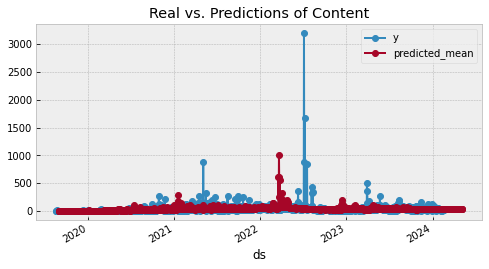

In [32]:
# make predictions
n = len(x)
pred = model_arima.predict(start = 10, end = n+183)

start_date = '2019-08-30'
num_predictions = len(pred)  # Length of the predictions DataFrame
date_range = pd.date_range(start=start_date, periods=num_predictions, freq='D')

pred.index =  pd.date_range(start=start_date, periods=len(pred))
_ = x.plot(figsize = (8,4), style = 'o-', legend = 'real', title = 'Real vs. Predictions of Content')
_ = pred.plot(figsize = (8,4), style = 'o-', legend = 'prediction')

In [33]:
pred

2019-08-30     2.704925
2019-08-31     3.800493
2019-09-01     2.585239
2019-09-02     2.712893
2019-09-03     2.164093
                ...    
2024-05-01    40.378975
2024-05-02    40.378975
2024-05-03    40.378975
2024-05-04    40.378975
2024-05-05    40.378975
Freq: D, Name: predicted_mean, Length: 1711, dtype: float64